# Event Detection Via Social Media Data
----
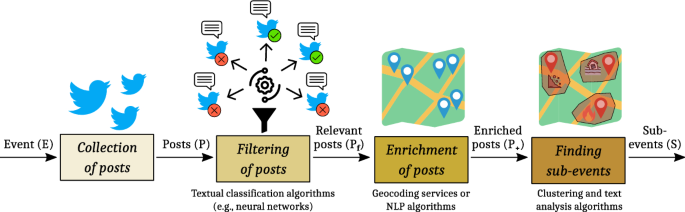

```
[Belcastro, L., Marozzo, F., Talia, D. et al. Using social media for sub-event detection during disasters. J Big Data 8, 79 (2021). https://doi.org/10.1186/s40537-021-00467-1]

```




##Data Overview

In [38]:
#@title install packages
# Install stanza
!pip install stanza

# Import and download Arabic model
import stanza
stanza.download('ar')  # Arabic models

# Define the NLP pipeline for Arabic NER
nlp = stanza.Pipeline(lang='ar', processors='tokenize,ner', use_gpu=False)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 84.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 36.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12

INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Downloading default packages for language: ar (Arabic) ...


INFO:stanza:Downloaded file to /root/stanza_resources/ar/default.zip
INFO:stanza:Finished downloading models and saved to /root/stanza_resources
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Loading these models for language: ar (Arabic):
| Processor | Package      |
----------------------------
| tokenize  | padt         |
| mwt       | padt         |
| ner       | aqmar_charlm |

INFO:stanza:Using device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: ner
INFO:stanza:Done loading processors!


In [1]:
#@title import packages
import numpy as np
import requests
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import pandas as pd
#@title import packages
import numpy as np
import requests
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import random
# import arabic_reshaper
# from bidi.algorithm import get_display
import matplotlib.pyplot as plt
from collections import Counter

import matplotlib.pyplot as plt
# import arabic_reshaper
# from bidi.algorithm import get_display
from collections import Counter
import ast
# import arabic_reshaper
# from bidi.algorithm import get_display
# from ar_wordcloud import ArabicWordCloud

import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import random
import networkx as nx


In [2]:
#@title uitlities
import re

def clean_tweet(text):
    if not isinstance(text, str):
        return ''
    text = re.sub(r'http\S+', '', text)            # remove URLs
    text = re.sub(r'@\w+', '', text)                # remove mentions
    text = re.sub(r'#\w+', '', text)                # remove hashtags
    text = re.sub(r'[^ء-يa-zA-Z0-9\s]', ' ', text) # keep Arabic letters, Latin letters, numbers, and spaces only
    text = re.sub(r'\s+', ' ', text)                 # remove extra whitespace
    return text.strip()

def extract_entities_stanza(text):
    if not isinstance(text, str) or text.strip() == "":
        return {"PER": [], "ORG": [], "LOC": [], "ALL": []}
    doc = nlp(text)
    per = []
    org = []
    loc = []
    for ent in doc.ents:
        if ent.type == "PER":
            per.append(ent.text)
        elif ent.type == "ORG":
            org.append(ent.text)
        elif ent.type == "LOC":
            loc.append(ent.text)
    all_entities = per + org + loc
    return {"PER": per, "ORG": org, "LOC": loc, "ALL": all_entities}




In [3]:
# @title Define Constants
urls = [
    "https://raw.githubusercontent.com/HasanKhadd0ur/SocialED_datasets/main/npy_data/Event2012.npy"
]
from google.colab import drive
drive.mount('/content/drive')

columns=[ 'tweet_id', 'text', 'event_id', 'words', 'filtered_words', 'entities', 'user_id', 'created_at', 'urls', 'hashtags', 'user_mentions']

Mounted at /content/drive


In [ ]:
#@title process data
# import os
# import pandas as pd

# # Define folder path in your Drive
# folder_path = '/content/drive/MyDrive/Events'

# # List CSV files only
# csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
# dataframes = []

# for label, filename in enumerate(csv_files):
#     file_path = os.path.join(folder_path, filename)
#     try:
#         df = pd.read_csv(file_path)
#         df['event_label'] = label  # Numeric label for each file
#         df['event_filename'] = filename  # Optional: store filename
#         dataframes.append(df)
#     except Exception as e:
#         print(f"Error reading {filename}: {e}")
# merged_df = pd.concat(dataframes, ignore_index=True)

# # Optional: Save to Drive or download
# merged_df.to_csv('/content/drive/MyDrive/merged_labeled_events.csv', index=False)

In [20]:
#@title Load dataset
df = pd.read_csv("/content/drive/MyDrive/merged_labeled_events.csv")

In [21]:
#@title Data Columns
df.columns

Index(['Tweet ID', 'Tweet Text', 'Type', 'Author Name', 'Author Username',
       'Creation Time', 'Reply Count', 'Retweet Count', 'Quote Count',
       'Like Count', 'View Count', 'Bookmark Count', 'Language',
       'Possibly Sensitive', 'Source', 'Hashtags', 'Tweet URL', 'Media Type',
       'Media URLs', 'External URLs', 'event_label', 'event_filename',
       'Hashtags_str', 'Old Tweet Text', 'Date', 'Block', 'duration_days',
       'duration_hours', 'duration_minutes'],
      dtype='object')

In [22]:
# @title Ensure Type
# Ensure datetime format
df['Creation Time'] = pd.to_datetime(df['Creation Time'])
import ast

def entities_to_list(entities_str):
    if isinstance(entities_str, str):
        try:
            # Safely evaluate the string to a Python list
            entities = ast.literal_eval(entities_str)
            # Ensure it's a list and strip whitespace from each entity
            if isinstance(entities, list):
                return [e.strip() for e in entities]
            else:
                return []
        except (ValueError, SyntaxError):
            return []
    else:
        return []

# Apply to the Named Entities column
# df['Named Entities'] = df['Named Entities'].apply(entities_to_list)



In [23]:
#@title Ensure hashtags are stored as lists instead of comma-separated strings
# def convert_hashtags_to_list(value):
#     if isinstance(value, str):
#         return [tag.strip() for tag in value.split(',') if tag.strip()]
#     return []

# df['Hashtags'] = df['Hashtags'].apply(convert_hashtags_to_list)
# Convert the string of hashtags separated by commas into a list, handling NaN

def hashtags_to_list(hstring):
    if isinstance(hstring, str):
        # Split by comma, strip whitespace
      return [tag.strip().lstrip('#') for tag in hstring.split(',') if tag.strip()]

    else:
        # For NaN or missing values
        return []
df['Hashtags_str'] = df['Hashtags']

# Apply conversion to your hashtag column, e.g., 'Hashtags_str'
df['Hashtags'] = df['Hashtags'].apply(hashtags_to_list)



In [24]:
# @title Data shape
print(df.shape)


(8428, 29)


In [25]:
#@title Clean the tweet texts
df['Old Tweet Text'] = df['Tweet Text']
df['Tweet Text'] = df['Tweet Text'].apply(clean_tweet)


## Explore Dataset

In [ ]:
#@title Some Sampels From the Dataset
df.sample(2)

,Tweet ID,Tweet Text,Type,Author Name,Author Username,Creation Time,Reply Count,Retweet Count,Quote Count,Like Count,...,Source,Hashtags,Tweet URL,Media Type,Media URLs,External URLs,event_label,event_filename,Hashtags_str,Old Tweet Text
6469,"=""1928105598924771470""",تهنئة محافظ غسان السيد أحمد بمناسبة توقيع اتفا...,Tweet,شبكة الشرقية 24,alsharqia24news,2025-05-29 18:06:11,0,0,0,0,...,Twitter Web App,"[ديرالزور, الشرقية24, سوريا]",https://x.com/alsharqia24news/status/192810559...,photo,https://pbs.twimg.com/media/GsIBz-VW4AEfO-e.jpg,NaN,76,TwSearchExporter-وزارة الطاقة سوريا since2025-...,"#ديرالزور, #الشرقية24, #سوريا",تهنئة محافظ #ديرالزور غسان السيد أحمد بمناسبة ...
6983,"=""1928498558304661661""",مئات من أبناء مدن تظاهروا أمام جامعة القلمون ر...,Tweet,Maimouna Khotaba,MaimounahK,2025-05-30 20:07:40,0,3,0,11,...,Twitter for Android,"[القلمون, سوريا, سليم_دعبول]",https://x.com/MaimounahK/status/19284985583046...,photo,https://pbs.twimg.com/media/GsNnN7PWAAAcG_A.jp...,NaN,87,TwSearchExporter- القلمون دعبول since2025-05-...,"#القلمون, #سوريا, #سليم_دعبول",مئات من أبناء مدن #القلمون تظاهروا أمام جامعة...


In [26]:
# @title Check for missing values
# Basic DataFrame info
df.info()

# Check for missing values
print("\nMissing values per column:\n", df.isna().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8428 entries, 0 to 8427
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Tweet ID            8428 non-null   object        
 1   Tweet Text          8428 non-null   object        
 2   Type                8428 non-null   object        
 3   Author Name         5578 non-null   object        
 4   Author Username     5578 non-null   object        
 5   Creation Time       8428 non-null   datetime64[ns]
 6   Reply Count         8428 non-null   int64         
 7   Retweet Count       8428 non-null   int64         
 8   Quote Count         8428 non-null   int64         
 9   Like Count          8428 non-null   int64         
 10  View Count          8396 non-null   float64       
 11  Bookmark Count      8428 non-null   int64         
 12  Language            8428 non-null   object        
 13  Possibly Sensitive  8428 non-null   object      

In [ ]:
# @title Describe the data
df.describe()

,Creation Time,Reply Count,Retweet Count,Quote Count,Like Count,View Count,Bookmark Count,event_label
count,9128,9128.000000,9128.000000,9128.000000,9128.000000,8.981000e+03,9128.000000,9128.000000
mean,2025-04-05 03:18:18.330412288,10.369303,19.759312,1.863168,142.048313,1.090879e+04,6.572305,51.217353
min,2013-02-16 20:23:59,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,2025-05-12 16:38:49,0.000000,0.000000,0.000000,0.000000,5.900000e+01,0.000000,14.000000
50%,2025-05-21 17:52:03,0.000000,0.000000,0.000000,2.000000,2.110000e+02,0.000000,53.000000
75%,2025-05-25 14:29:26,1.000000,2.000000,0.000000,18.000000,1.446000e+03,1.000000,84.000000
max,2025-06-01 08:40:56,3779.000000,13406.000000,2208.000000,46436.000000,6.139862e+06,2906.000000,108.000000
std,NaN,89.179184,202.007454,27.389757,1023.000587,1.026422e+05,62.476440,36.269795


In [27]:
#@title Ensure Time are in  May 2025
# @markdown The range of the data is from 1 May 2025 to 30 May 2025

timestamp_column = 'Creation Time'



# Filter to keep only tweets from May 2025
df = df[
    (df[timestamp_column].dt.year == 2025) &
    # (df[timestamp_column].dt.month == 5  or 4)
    (df[timestamp_column].dt.month > 1) &
    (df[timestamp_column].dt.month < 6)
]

print(f"Filtered DataFrame has {len(df)} tweets from May 2025.")

print(df[timestamp_column].min(), df[timestamp_column].max())

Filtered DataFrame has 8428 tweets from May 2025.
2025-02-01 00:08:16 2025-05-31 23:12:46


In [ ]:
# @title The Number of events
# @markdown The number of events is 109
print(df["event_label"].nunique())

109


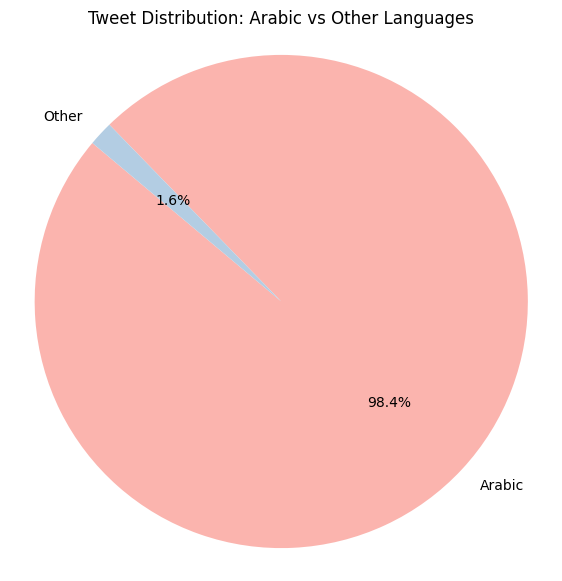

In [ ]:
#@title Languages Distribution
# Count languages
language_counts = df['Language'].value_counts()

arabic_lang = 'ar'  # change if needed
arabic_count = language_counts.get(arabic_lang, 0)

# Sum of all non-Arabic languages
other_count = language_counts.sum() - arabic_count

# Create series for pie chart
pie_counts = [arabic_count, other_count]
labels = ['Arabic', 'Other']

# Plot pie chart
plt.figure(figsize=(7,7))
plt.pie(pie_counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Pastel1.colors)
plt.title('Tweet Distribution: Arabic vs Other Languages')
plt.axis('equal')  # Make pie circular
plt.show()


In [28]:
# @title Remove Non-Arabic Tweets and Duplicate Tweets

# Show original shape
print(f"Original shape: {df.shape}")

# Keep only Arabic tweets, assuming 'ar' is the language code for Arabic
df = df[df['Language'] == 'ar'].reset_index(drop=True)

print(f"Shape after filtering non-Arabic tweets: {df.shape}")

# Drop duplicate tweets based on the 'Tweet Text' column (case-sensitive)
df = df.drop_duplicates(subset='Tweet Text').reset_index(drop=True)

# Show new shape
print(f"Shape after removing duplicates: {df.shape}")


Original shape: (8428, 29)
Shape after filtering non-Arabic tweets: (8292, 29)
Shape after removing duplicates: (6998, 29)


In [13]:

#@title  Calculate event duration
event_durations = df.groupby('event_filename')['Creation Time'].agg(['min', 'max'])
time_diff = event_durations['max'] - event_durations['min']

# Add duration columns
event_durations['duration_days'] = time_diff.dt.total_seconds() / (3600 * 24)
event_durations['duration_hours'] = time_diff.dt.total_seconds() / 3600
event_durations['duration_minutes'] = time_diff.dt.total_seconds() / 60

# Merge durations back to original df
df = df.merge(
    event_durations[['duration_days', 'duration_hours', 'duration_minutes']],
    on='event_filename'
)



In [ ]:
#@title The Duration of Events
# Group by event and get start/end dates
event_times = df.groupby('event_label')['Creation Time'].agg(['min', 'max'])

# Calculate duration in days
event_times['duration_days'] = (event_times['max'] - event_times['min']).dt.days

# Calculate duration in minutes
event_times['duration_minutes'] = ((event_times['max'] - event_times['min']).dt.total_seconds() / 60).astype(int)


# Calculate duration in hours
event_times['duration_hours'] = ((event_times['max'] - event_times['min']).dt.total_seconds() / 3600 ).astype(int)

event_times[['duration_days', 'duration_minutes', 'duration_hours']].sample(3)

,duration_days,duration_minutes,duration_hours
event_label,,,
68,0,230,3
47,0,3,0
40,0,1036,17


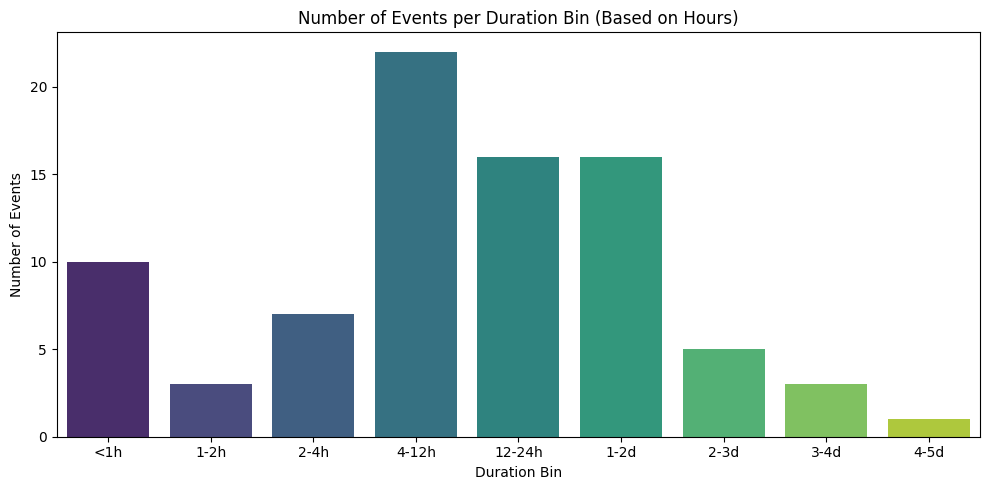

In [ ]:
#@title The Duration of Events
# Define bins in hours
bins = [0, 1, 2, 4, 12, 24, 48, 72, 96, 120]  # in hours
labels = ['<1h', '1-2h', '2-4h', '4-12h', '12-24h', '1-2d', '2-3d', '3-4d', '4-5d']

# Assign duration bin based on duration_hours
event_times['duration_bin'] = pd.cut(event_times['duration_hours'], bins=bins, labels=labels, right=False)

# Count events per bin
bin_counts = event_times['duration_bin'].value_counts().sort_index()

# Plot the count of events per duration bin
plt.figure(figsize=(10, 5))
sns.barplot(
    x=bin_counts.index,
    y=bin_counts.values,
    hue=bin_counts.index,
    palette="viridis",
    legend=False
)
plt.title("Number of Events per Duration Bin (Based on Hours)")
plt.xlabel("Duration Bin")
plt.ylabel("Number of Events")
plt.tight_layout()
plt.show()


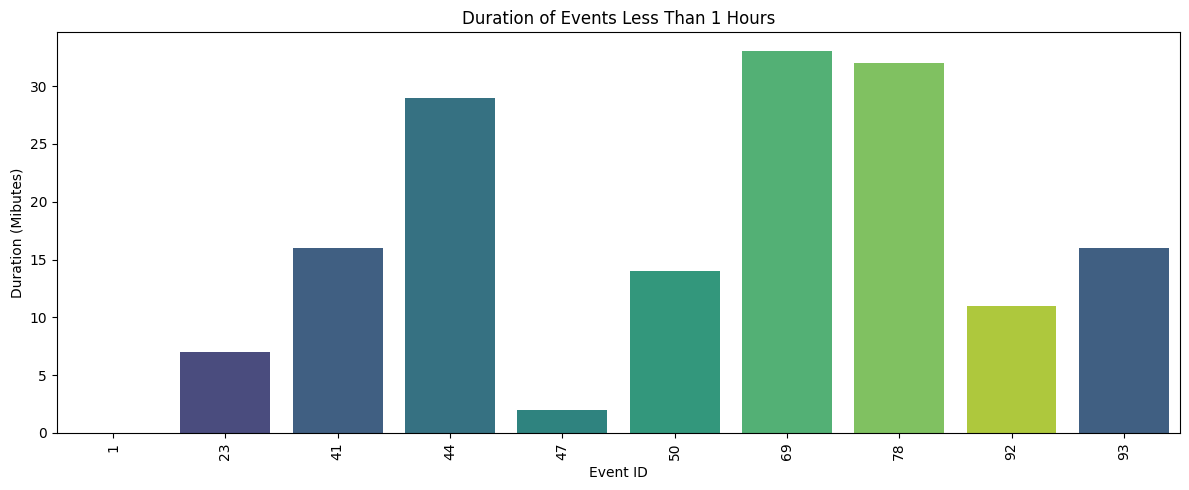

In [ ]:
#@title Plot Events with Duration Less Than 2 Hours

# Filter events with duration less than 1 Hours
short_events = event_times[event_times['duration_minutes'] < 50]

# Plot the duration of short events
plt.figure(figsize=(12, 5))
sns.barplot(
    x=short_events.index.astype(str),
    y=short_events['duration_minutes'],
    hue=short_events['duration_minutes'].astype(str),
    palette="viridis",
    legend=False
)
plt.title("Duration of Events Less Than 1 Hours")
plt.xlabel("Event ID")
plt.ylabel("Duration (Mibutes)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


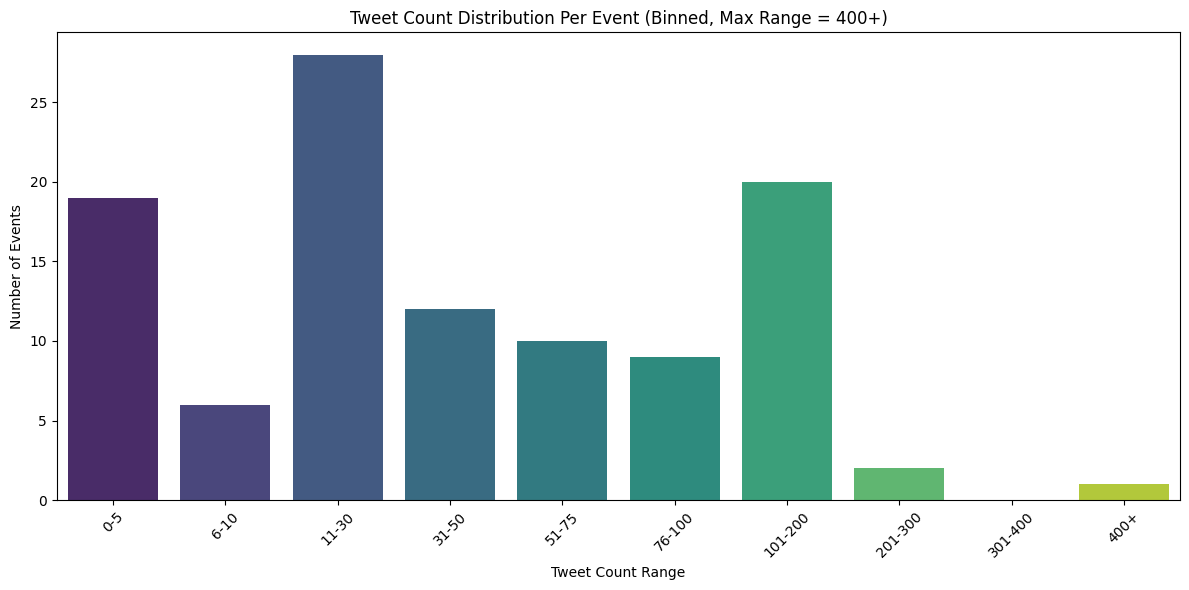

In [ ]:
# @title The Number of Tweets per Event

# Count the number of tweets per event label
tweet_counts = df['event_label'].value_counts()

# Define bins and labels with a maximum range of 400+
bins = [0, 5, 10, 30, 50, 75, 100, 200, 300, 400, float('inf')]
bin_labels = ['0-5', '6-10', '11-30', '31-50', '51-75', '76-100',
              '101-200', '201-300', '301-400', '400+']

# Assign tweet counts to bins
tweet_counts_binned = pd.cut(tweet_counts, bins=bins, labels=bin_labels)

# Count number of events in each bin
bin_counts = tweet_counts_binned.value_counts().sort_index()

# Plot the distribution
plt.figure(figsize=(12, 6))
sns.barplot(
    x=bin_counts.index,
    y=bin_counts.values,
    hue=bin_counts.index,
    palette="viridis",
    legend=False
)
plt.title("Tweet Count Distribution Per Event (Binned, Max Range = 400+)")
plt.xlabel("Tweet Count Range")
plt.ylabel("Number of Events")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Selected event label: 70
downloading and unzipping arabic font: /usr/local/lib/python3.11/dist-packages/ar_wordcloud/fonts/NotoNaskhArabic-unhinted.zip .. 
downloading and unzipping arabic font: /usr/local/lib/python3.11/dist-packages/ar_wordcloud/fonts/NotoSansArabic-unhinted.zip .. 
downloading and unzipping arabic font: /usr/local/lib/python3.11/dist-packages/ar_wordcloud/fonts/NotoKufiArabic-unhinted.zip .. 


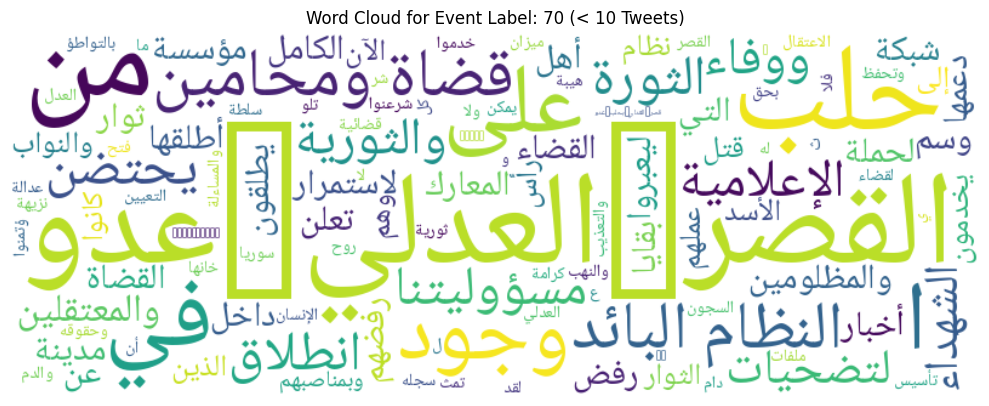

In [ ]:
# @title Word Cloud for a Selected Small Event (< 10 Tweets)

import arabic_reshaper
from bidi.algorithm import get_display
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Step 1: Get events with fewer than 10 tweets
small_events = tweet_counts[tweet_counts < 10].index.tolist()

# Step 2: Select an event from the small events list
# Replace this with the event label you want to visualize
selected_event = small_events[0]  # For example, choose the first event from the list

print(f"Selected event label: {selected_event}")

# Step 3: Filter tweets for the selected event
event_df = df[df['event_label'] == selected_event]

# Step 4: Combine all tweet texts into one string
all_text = ' '.join(event_df['Tweet Text'].dropna().astype(str))

# Step 5: Reshape and apply bidi for Arabic display
reshaped_text = arabic_reshaper.reshape(all_text)
display_text = get_display(reshaped_text)

# Step 6: Generate and display the word cloud
wordcloud =  ArabicWordCloud(
            width=800,
            height=300,
            background_color='white'
        ).generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title(f"Word Cloud for Event Label: {selected_event} (< 10 Tweets)")
plt.tight_layout()
plt.show()


Selected random event label: 1


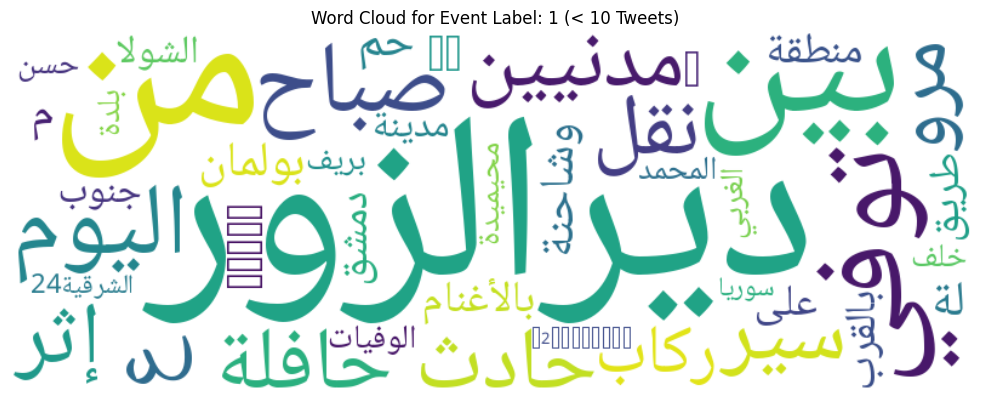

In [ ]:
#@title Word Cloud For An Event


# Step 1: Find event labels in df with less than 10 tweets
event_tweet_counts = df['event_label'].value_counts()
small_events = event_tweet_counts[event_tweet_counts < 10].index.tolist()

# Step 2: Choose a random event label from those
selected_event = random.choice(small_events)
print(f"Selected random event label: {selected_event}")

# Step 3: Filter df for this event
event_df = df[df['event_label'] == selected_event]

# Step 4: Combine all tweet texts into a single string
all_text = ' '.join(event_df['Tweet Text'].dropna().astype(str))


# Step 6: Generate and display the word cloud
wordcloud = ArabicWordCloud(
    width=800,
    height=300,
    background_color='white'
).generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title(f"Word Cloud for Event Label: {selected_event} (< 10 Tweets)")
plt.tight_layout()
plt.show()

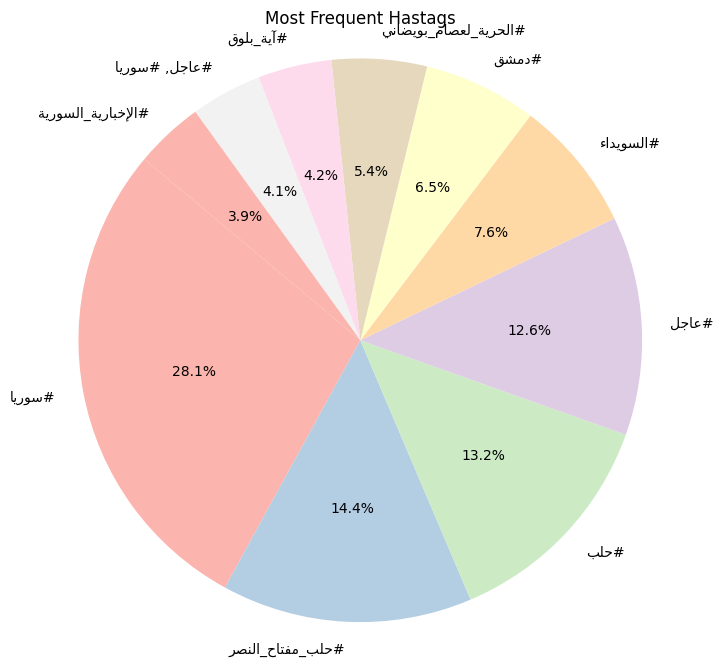

In [ ]:
#@title Frequent Hashtags
# Prepare hashtag counts
all_hashtags = df['Hashtags'].dropna().apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else [x])
flattened = [tag for sublist in all_hashtags for tag in sublist]
hashtag_counts = Counter(flattened)

# Extract top 10 hashtags
top_hashtags = hashtag_counts.most_common(10)
labels, counts = zip(*top_hashtags)

# Reshape and reorder Arabic labels
reshaped_labels = [get_display(arabic_reshaper.reshape(label)) for label in labels]

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=reshaped_labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Pastel1.colors)
plt.title("Most Frequent Hastags")
plt.axis('equal')  # Equal aspect ratio ensures pie is circular.
plt.show()


In [29]:
#@title Divide the Data set into blocks
from pathlib import Path

# Define output directory
output_dir = Path("drive/MyDrive/daily_message_blocks")
output_dir.mkdir(parents=True, exist_ok=True)

# Extract date (YYYY-MM-DD)
df["Date"] = df["Creation Time"].dt.date

# Separate messages before 1 May 2025
before_may = df[df["Creation Time"] < pd.Timestamp("2025-05-01")]
before_may_file = output_dir / "messages_before_2025-05-01.csv"
before_may.drop(columns=["Date"]).to_csv(before_may_file, index=False)
print(f"🕰️ Saved {len(before_may)} messages before 2025-05-01 → {before_may_file}")

# Filter messages from 1 May and onward
df_may = df[df["Creation Time"] >= pd.Timestamp("2025-05-01")]

# Group by date and save each group
for date, group in df_may.groupby("Date"):
    file_name = output_dir / f"messages_{date}.csv"
    group.drop(columns=["Date"]).to_csv(file_name, index=False)
    print(f"📅 Saved {len(group)} messages for {date} → {file_name}")

# # Create output directory
# output_dir = Path("drive/MyDrive/daily_message_blocks")
# output_dir.mkdir(parents=True, exist_ok=True)

# # Group by date and save each group
# for date, group in df.groupby("Date"):
#     file_name = output_dir / f"messages_{date}.csv"
#     group.drop(columns=["Date"]).to_csv(file_name, index=False)
#     print(f"Saved {len(group)} messages for {date} → {file_name}")


🕰️ Saved 326 messages before 2025-05-01 → drive/MyDrive/daily_message_blocks/messages_before_2025-05-01.csv
📅 Saved 75 messages for 2025-05-01 → drive/MyDrive/daily_message_blocks/messages_2025-05-01.csv
📅 Saved 54 messages for 2025-05-02 → drive/MyDrive/daily_message_blocks/messages_2025-05-02.csv
📅 Saved 87 messages for 2025-05-03 → drive/MyDrive/daily_message_blocks/messages_2025-05-03.csv
📅 Saved 21 messages for 2025-05-04 → drive/MyDrive/daily_message_blocks/messages_2025-05-04.csv
📅 Saved 68 messages for 2025-05-05 → drive/MyDrive/daily_message_blocks/messages_2025-05-05.csv
📅 Saved 303 messages for 2025-05-06 → drive/MyDrive/daily_message_blocks/messages_2025-05-06.csv
📅 Saved 57 messages for 2025-05-07 → drive/MyDrive/daily_message_blocks/messages_2025-05-07.csv
📅 Saved 85 messages for 2025-05-08 → drive/MyDrive/daily_message_blocks/messages_2025-05-08.csv
📅 Saved 16 messages for 2025-05-09 → drive/MyDrive/daily_message_blocks/messages_2025-05-09.csv
📅 Saved 81 messages for 202

<ipython-input-14-2988921368>:22: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


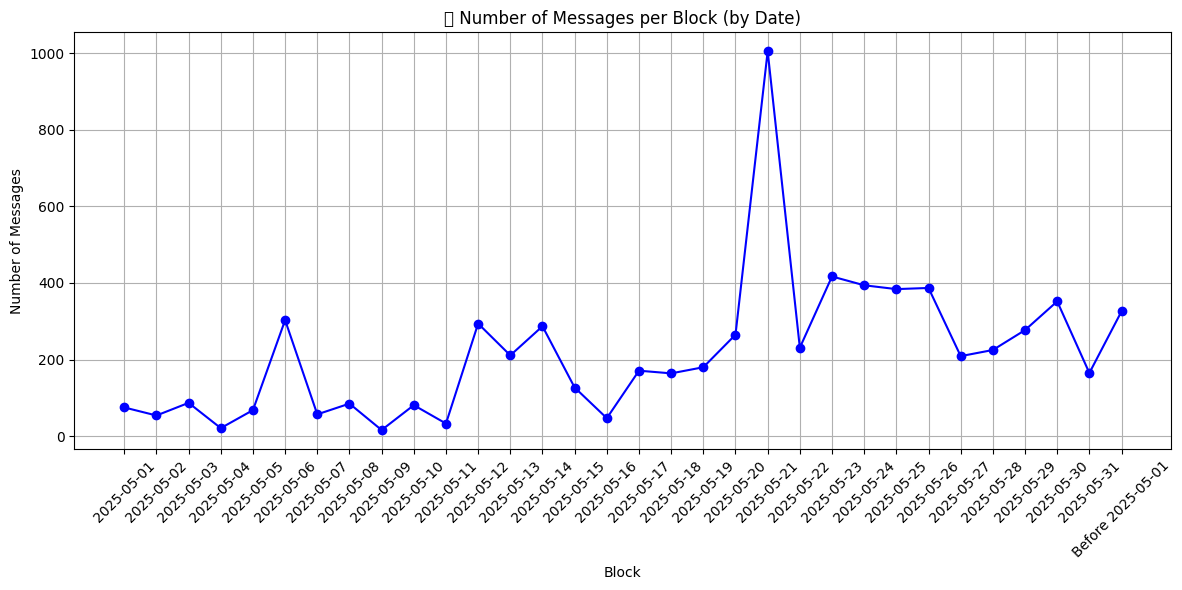

In [14]:
#@title Messages Blocks
# Create 'Date' column for grouping
df["Date"] = df["Creation Time"].dt.date

# Relabel dates before May 1, 2025 as a single block
df["Block"] = df["Date"].apply(lambda d: "Before 2025-05-01" if d < pd.to_datetime("2025-05-01").date() else str(d))

# Group by block
block_stats = df.groupby("Block").agg(
    Block_Size=("Tweet ID", "count"),
    Num_Events=("event_filename", pd.Series.nunique)
).reset_index()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(block_stats["Block"], block_stats["Block_Size"], marker='o', color='blue')
plt.xticks(rotation=45)
plt.title("📦 Number of Messages per Block (by Date)")
plt.xlabel("Block")
plt.ylabel("Number of Messages")
plt.grid(True)
plt.tight_layout()
plt.show()


In [30]:
# @title Show the table
print("\n📊 Daily Block Summary:\n")
print(block_stats.rename(columns={"Block": "Block (Date)"}).to_string(index=False))



📊 Daily Block Summary:

     Block (Date)  Block_Size  Num_Events
       2025-05-01          75           8
       2025-05-02          54           9
       2025-05-03          87          12
       2025-05-04          21           6
       2025-05-05          68           7
       2025-05-06         303          11
       2025-05-07          57           8
       2025-05-08          85          10
       2025-05-09          16           7
       2025-05-10          81           8
       2025-05-11          33           8
       2025-05-12         294          10
       2025-05-13         211           8
       2025-05-14         287           8
       2025-05-15         127          10
       2025-05-16          47           9
       2025-05-17         171          12
       2025-05-18         164          12
       2025-05-19         180          16
       2025-05-20         265          19
       2025-05-21        1005          20
       2025-05-22         231          14
       20

<ipython-input-31-2911011030>:26: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


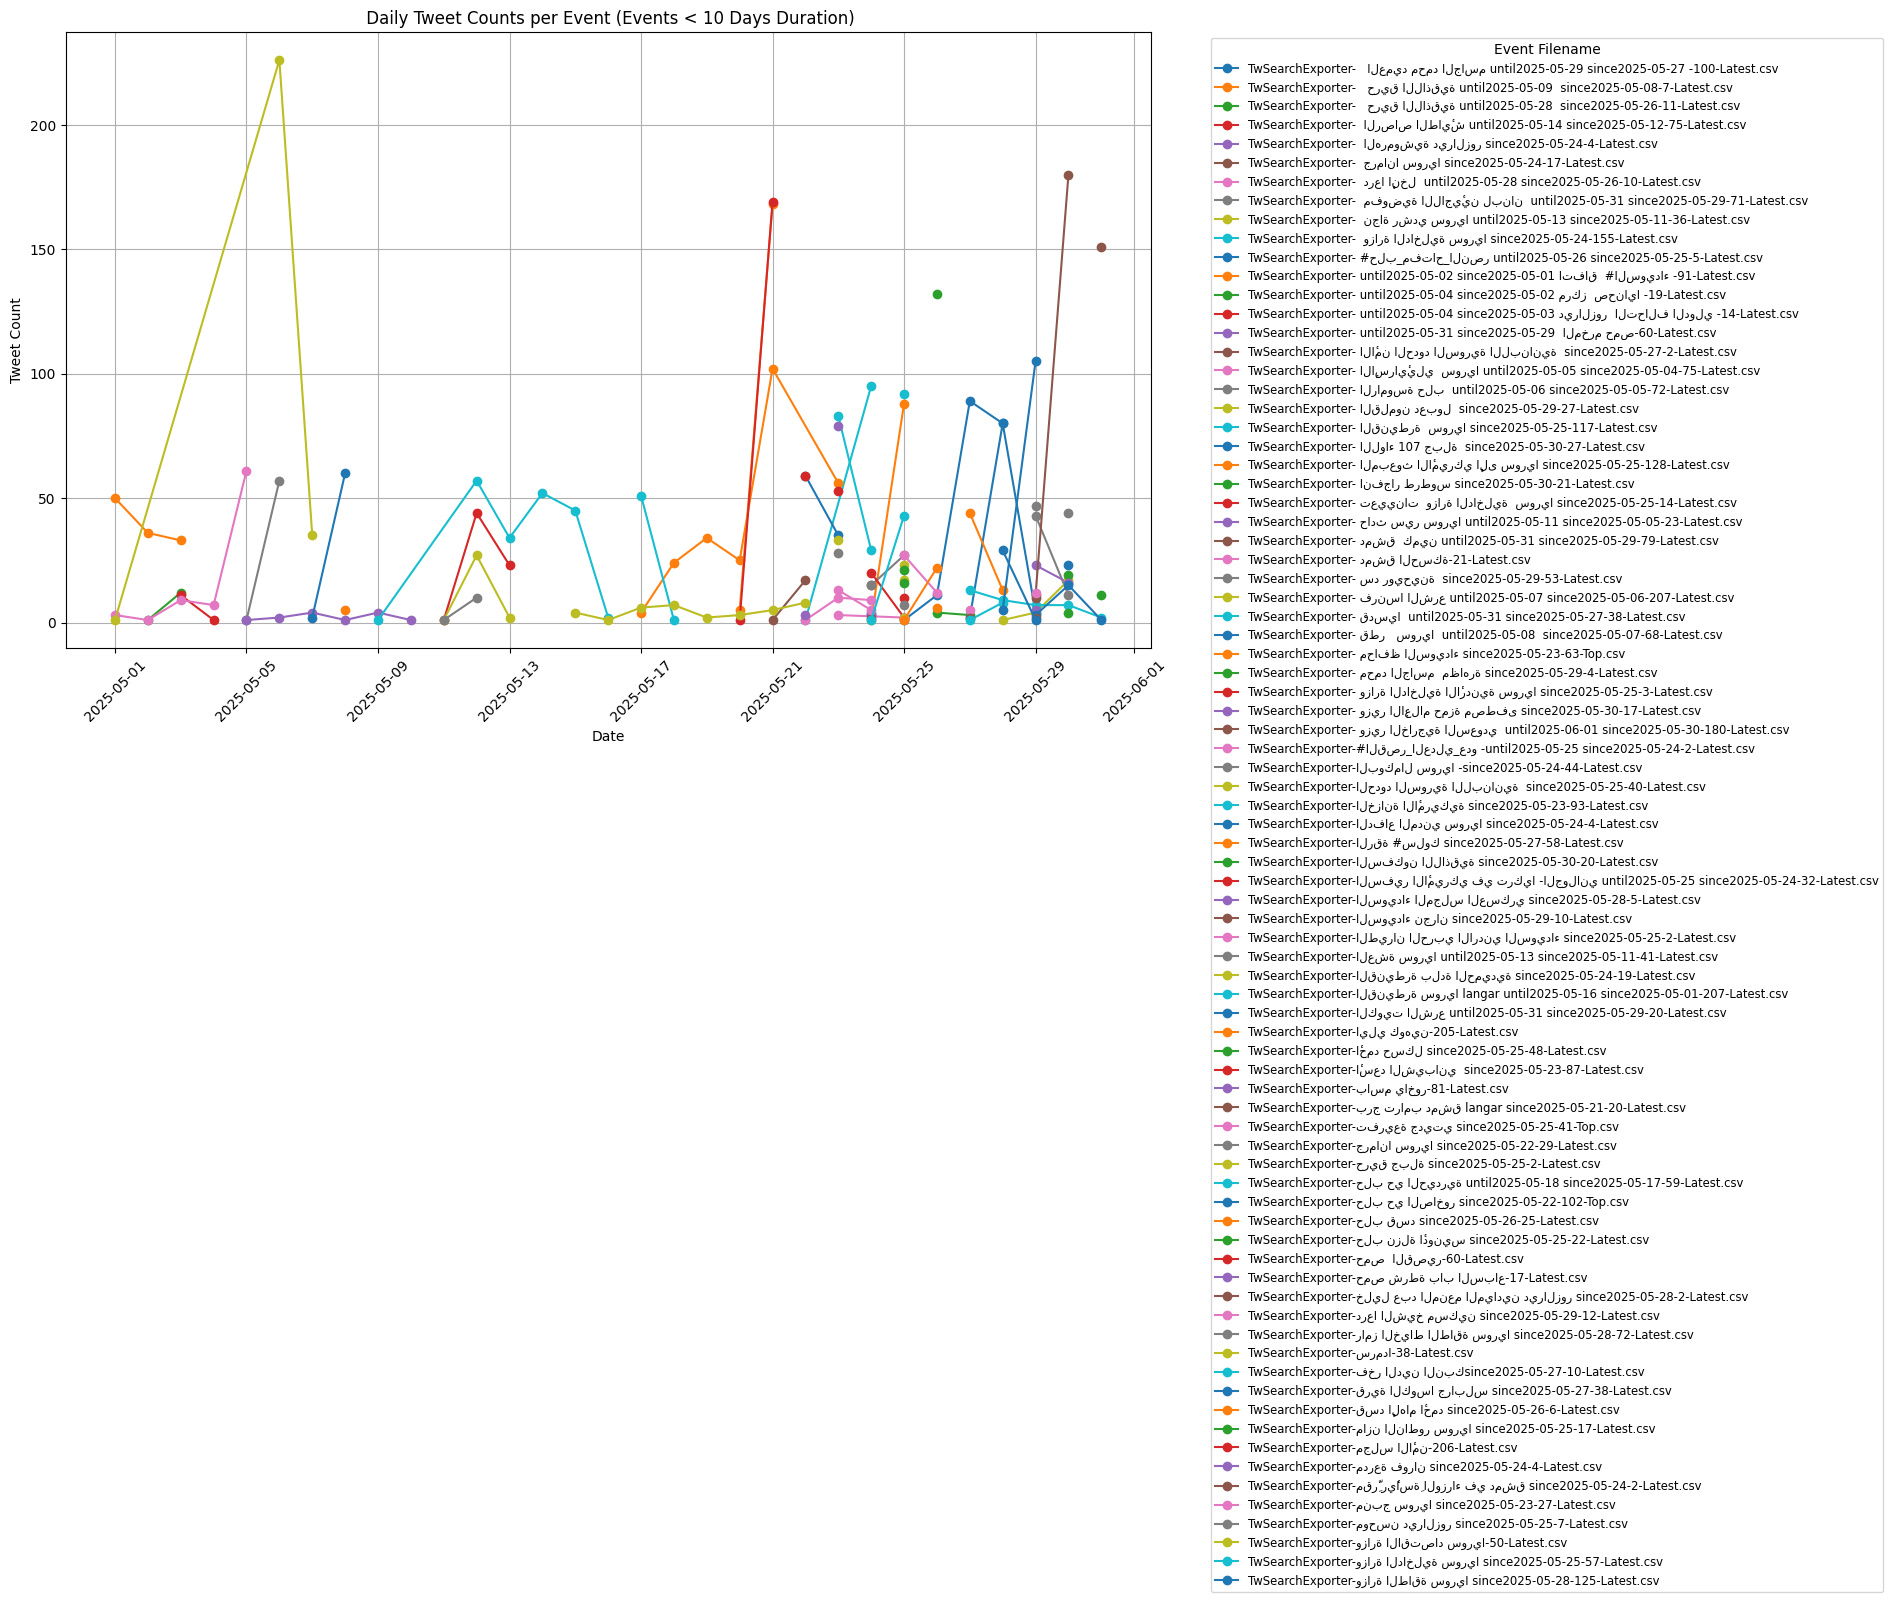


🔍 Summary Statistics (Filtered):
Total Tweets: 4029
Unique Days: 31
Unique Events: 81


In [31]:
#@title events duration
# Filter events with duration less than 5 days
filtered_df = df[df['duration_days'] < 10].copy()

# Extract Date from Creation Time
filtered_df['Date'] = filtered_df['Creation Time'].dt.date

# Group by event and date to count tweets per event per day
event_daily_counts = filtered_df.groupby(['event_filename', 'Date']).agg(
    Tweets_Per_Day=("Tweet ID", "count")
).reset_index()

# Plot line for each event
plt.figure(figsize=(14, 8))

# Iterate over each event and plot its daily tweet counts
for event_name, group in event_daily_counts.groupby('event_filename'):
    plt.plot(group['Date'], group['Tweets_Per_Day'], marker='o', label=event_name)

plt.title(" Daily Tweet Counts per Event (Events < 10 Days Duration)")
plt.xlabel("Date")
plt.ylabel("Tweet Count")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='Event Filename', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

# Stats summary
print("\n🔍 Summary Statistics (Filtered):")
print(f"Total Tweets: {len(filtered_df)}")
print(f"Unique Days: {filtered_df['Date'].nunique()}")
print(f"Unique Events: {filtered_df['event_filename'].nunique()}")
# Remove prefix from event_filename
# df['event_filename'] = df['event_filename'].str.replace(r'^TwSearchExporter-', '', regex=True)


<ipython-input-32-2519557469>:113: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


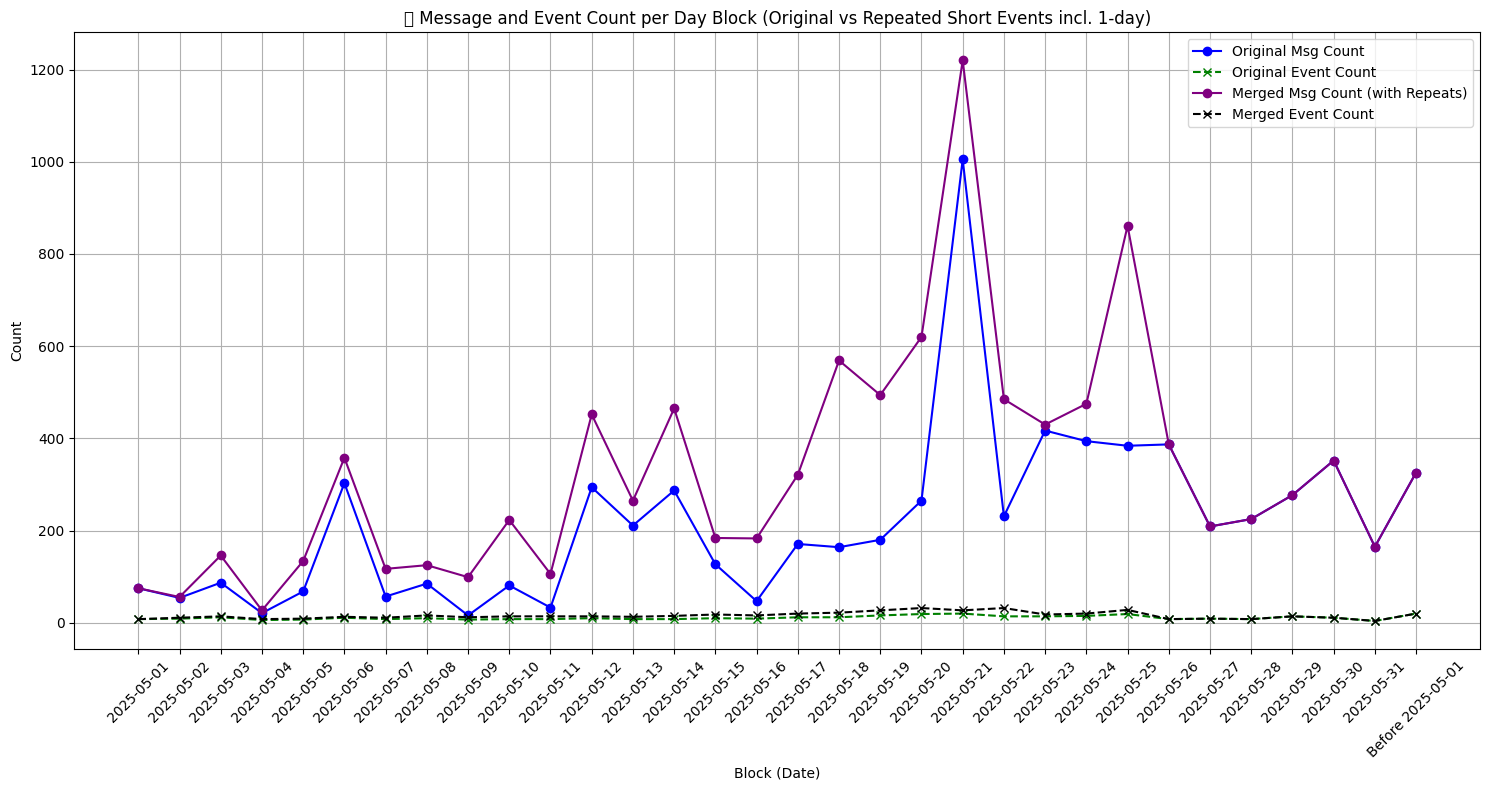

In [32]:
#@title Augment the data by repeating the events
from datetime import timedelta

# Ensure 'Date' column is datetime.date type
if df['Date'].dtype != 'O':
    df['Date'] = pd.to_datetime(df['Date']).dt.date

start_date = pd.to_datetime("2025-05-01").date()
end_date = pd.to_datetime("2025-05-25").date()

# Assign Block column
df['Block'] = df['Date'].apply(lambda d: "Before 2025-05-01" if d < start_date else str(d))

# Original stats
block_stats = df.groupby('Block').agg(
    Block_Size=('Tweet ID', 'count'),
    Num_Events=('event_filename', pd.Series.nunique)
).reset_index()

# --- Step 1: Detect short events (< 5 days) and 1-day events
event_durations = df.groupby('event_filename')['Creation Time'].agg(['min', 'max'])
event_durations['duration_days'] = (event_durations['max'] - event_durations['min']).dt.total_seconds() / 86400
event_durations['start_date'] = event_durations['min'].dt.date
event_durations['end_date'] = event_durations['max'].dt.date

short_events = event_durations[event_durations['duration_days'] < 5]
one_day_events = event_durations[event_durations['duration_days'] == 1.0]

# Extract only short event rows in range
filtered_df = df[
    (df['event_filename'].isin(short_events.index)) &
    (df['Date'] >= start_date) & (df['Date'] <= end_date)
].copy()

# Precompute daily counts
daily_counts = df[df['Date'] >= start_date].groupby('Date').size().to_dict()
augmented_rows = []

# Augment short events (< 5 days)
for event_name, row in short_events.iterrows():
    original_rows = filtered_df[filtered_df['event_filename'] == event_name]
    if original_rows.empty:
        continue

    candidates = []
    for shift in [-3, 3, 7, 10]:
        target_date = row['end_date'] + timedelta(days=shift) if shift >= 0 else row['start_date'] + timedelta(days=shift)
        if start_date <= target_date <= end_date and daily_counts.get(target_date, 0) < 500:
            candidates.append(target_date)

    used_targets = set()
    for target_date in candidates:
        if target_date in used_targets:
            continue
        used_targets.add(target_date)

        shift_days = (target_date - row['start_date']).days
        repeated_rows = original_rows.copy()
        repeated_rows['Date'] = repeated_rows['Date'] + timedelta(days=shift_days)
        repeated_rows = repeated_rows[(repeated_rows['Date'] >= start_date) & (repeated_rows['Date'] <= end_date)]
        if not repeated_rows.empty:
            augmented_rows.append(repeated_rows)

# Augment 1-day events with more shifts
filtered_one_day = df[
    (df['event_filename'].isin(one_day_events.index)) &
    (df['Date'] >= start_date) & (df['Date'] <= end_date)
].copy()

for event_name, row in one_day_events.iterrows():
    original_rows = filtered_one_day[filtered_one_day['event_filename'] == event_name]
    if original_rows.empty:
        continue

    for shift in [-7, -3, 3, 7]:
        target_date = row['start_date'] + timedelta(days=shift)
        if start_date <= target_date <= end_date and daily_counts.get(target_date, 0) < 500:
            repeated_rows = original_rows.copy()
            repeated_rows['Date'] = repeated_rows['Date'] + timedelta(days=shift)
            repeated_rows = repeated_rows[(repeated_rows['Date'] >= start_date) & (repeated_rows['Date'] <= end_date)]
            if not repeated_rows.empty:
                augmented_rows.append(repeated_rows)

# Merge repeated events
repeated_df = pd.concat(augmented_rows, ignore_index=True) if augmented_rows else pd.DataFrame(columns=df.columns)
repeated_df['is_augmented'] = True

# Merge with original
merged_df = pd.concat([df, repeated_df], ignore_index=True)
merged_df['Block'] = merged_df['Date'].apply(lambda d: "Before 2025-05-01" if d < start_date else str(d))

# Recompute block stats
merged_block_stats = merged_df.groupby('Block').agg(
    Block_Size=('Tweet ID', 'count'),
    Num_Events=('event_filename', pd.Series.nunique)
).reset_index()

# --- 📊 Plot comparison
plt.figure(figsize=(15, 8))

plt.plot(block_stats['Block'], block_stats['Block_Size'], marker='o', color='blue', label='Original Msg Count')
plt.plot(block_stats['Block'], block_stats['Num_Events'], marker='x', color='green', linestyle='--', label='Original Event Count')

plt.plot(merged_block_stats['Block'], merged_block_stats['Block_Size'], marker='o', color='purple', label='Merged Msg Count (with Repeats)')
plt.plot(merged_block_stats['Block'], merged_block_stats['Num_Events'], marker='x', color='black', linestyle='--', label='Merged Event Count')

plt.xticks(rotation=45)
plt.title("📦 Message and Event Count per Day Block (Original vs Repeated Short Events incl. 1-day)")
plt.xlabel("Block (Date)")
plt.ylabel("Count")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [33]:
#@title Augmented Blocks Stats
print("\n📅 Merged Block Stats (Date, Number of Events, Size):\n")
print(merged_block_stats[['Block', 'Num_Events', 'Block_Size']].to_string(index=False))



📅 Merged Block Stats (Date, Number of Events, Size):

            Block  Num_Events  Block_Size
       2025-05-01           8          75
       2025-05-02          11          56
       2025-05-03          14         146
       2025-05-04           8          27
       2025-05-05           9         134
       2025-05-06          13         358
       2025-05-07          11         117
       2025-05-08          16         125
       2025-05-09          12          99
       2025-05-10          14         223
       2025-05-11          14         106
       2025-05-12          14         452
       2025-05-13          13         265
       2025-05-14          15         465
       2025-05-15          18         184
       2025-05-16          16         183
       2025-05-17          20         321
       2025-05-18          22         569
       2025-05-19          27         494
       2025-05-20          32         620
       2025-05-21          27        1220
       2025-05-22    

In [34]:

# @title Save merged block stats to CSV
csv_path = "drive/MyDrive/merged_block_stats.csv"
merged_block_stats.to_csv(csv_path, index=False)
print(f"✅ Merged block statistics saved to: {csv_path}")


✅ Merged block statistics saved to: drive/MyDrive/merged_block_stats.csv


<ipython-input-35-2026108580>:99: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


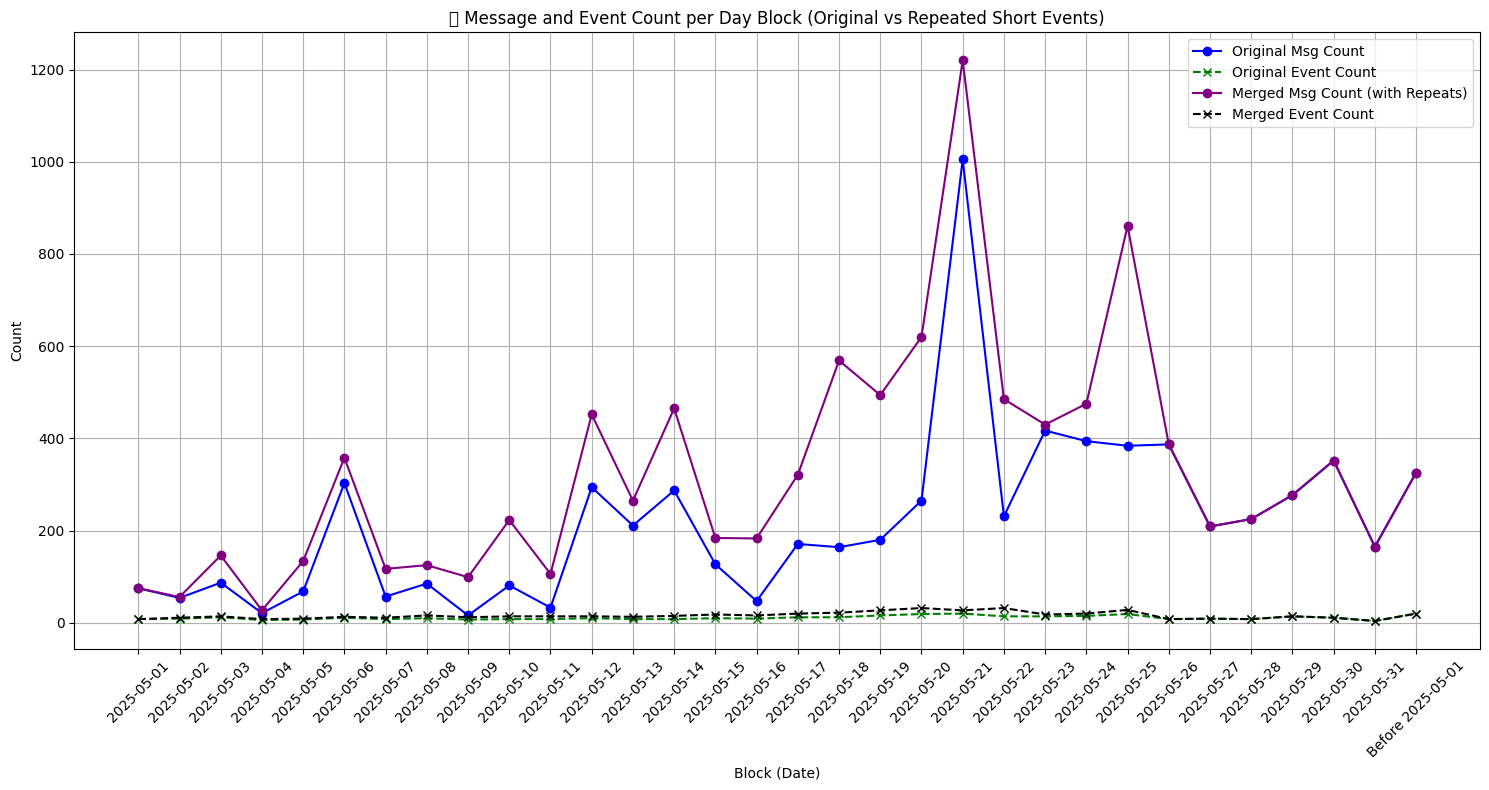

In [35]:
#@title Augmenting the Data By Shifting the days
import matplotlib.pyplot as plt
import pandas as pd
from datetime import timedelta

# Ensure 'Date' column is datetime.date type
if df['Date'].dtype != 'O':
    df['Date'] = pd.to_datetime(df['Date']).dt.date

start_date = pd.to_datetime("2025-05-01").date()
end_date = pd.to_datetime("2025-05-25").date()

# Assign Block column
df['Block'] = df['Date'].apply(lambda d: "Before 2025-05-01" if d < start_date else str(d))

# Original stats
block_stats = df.groupby('Block').agg(
    Block_Size=('Tweet ID', 'count'),
    Num_Events=('event_filename', pd.Series.nunique)
).reset_index()

# --- Step 1: Detect short events (< 5 days)
event_durations = df.groupby('event_filename')['Creation Time'].agg(['min', 'max'])
event_durations['duration_days'] = (event_durations['max'] - event_durations['min']).dt.total_seconds() / 86400
event_durations['start_date'] = event_durations['min'].dt.date
event_durations['end_date'] = event_durations['max'].dt.date

short_events = event_durations[event_durations['duration_days'] < 5]

# Extract only short event rows in range
filtered_df = df[
    (df['event_filename'].isin(short_events.index)) &
    (df['Date'] >= start_date) &
    (df['Date'] <= end_date)
].copy()

# Precompute daily counts
daily_counts = df[df['Date'] >= start_date].groupby('Date').size().to_dict()
augmented_rows = []

for event_name, row in short_events.iterrows():
    original_rows = filtered_df[filtered_df['event_filename'] == event_name]
    if original_rows.empty:
        continue

    candidates = []

    # Add potential shifts (after end and before start)
    for shift in [-3, 3, 7, 10]:
        target_date = row['end_date'] + timedelta(days=shift) if shift >= 0 else row['start_date'] + timedelta(days=shift)
        if start_date <= target_date <= end_date and daily_counts.get(target_date, 0) < 500:
            candidates.append(target_date)

    used_targets = set()
    for target_date in candidates:
        if target_date in used_targets:
            continue
        used_targets.add(target_date)

        shift_days = (target_date - row['start_date']).days
        repeated_rows = original_rows.copy()
        repeated_rows['Date'] = repeated_rows['Date'] + timedelta(days=shift_days)

        # Remove out-of-range
        repeated_rows = repeated_rows[(repeated_rows['Date'] >= start_date) & (repeated_rows['Date'] <= end_date)]

        if not repeated_rows.empty:
            augmented_rows.append(repeated_rows)

# Merge repeated short events
repeated_df = pd.concat(augmented_rows, ignore_index=True) if augmented_rows else pd.DataFrame(columns=df.columns)
repeated_df['is_augmented'] = True

# Merge with original
merged_df = pd.concat([df, repeated_df], ignore_index=True)
merged_df['Block'] = merged_df['Date'].apply(lambda d: "Before 2025-05-01" if d < start_date else str(d))

# Recompute block stats
merged_block_stats = merged_df.groupby('Block').agg(
    Block_Size=('Tweet ID', 'count'),
    Num_Events=('event_filename', pd.Series.nunique)
).reset_index()

# --- 📊 Plot comparison
plt.figure(figsize=(15, 8))

plt.plot(block_stats['Block'], block_stats['Block_Size'], marker='o', color='blue', label='Original Msg Count')
plt.plot(block_stats['Block'], block_stats['Num_Events'], marker='x', color='green', linestyle='--', label='Original Event Count')

plt.plot(merged_block_stats['Block'], merged_block_stats['Block_Size'], marker='o', color='purple', label='Merged Msg Count (with Repeats)')
plt.plot(merged_block_stats['Block'], merged_block_stats['Num_Events'], marker='x', color='black', linestyle='--', label='Merged Event Count')

plt.xticks(rotation=45)
plt.title("📦 Message and Event Count per Day Block (Original vs Repeated Short Events)")
plt.xlabel("Block (Date)")
plt.ylabel("Count")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [39]:
#@title Extract Named Entites
from concurrent.futures import ThreadPoolExecutor

# Use ThreadPool to speed up processing
texts = df['Tweet Text'].tolist()


# Run NER extraction in parallel
with ThreadPoolExecutor(max_workers=8) as executor:
    entities_list = list(executor.map(extract_entities_stanza, texts))

# Create new columns in DataFrame from extracted entities
df['Named Entities'] = [e['ALL'] for e in entities_list]
df['PER'] = [e['PER'] for e in entities_list]
df['ORG'] = [e['ORG'] for e in entities_list]
df['LOC'] = [e['LOC'] for e in entities_list]

In [43]:
#@title Some Named Entities
df[['Named Entities',"PER","ORG","LOC"]].sample(4)

,Named Entities,PER,ORG,LOC
1846,[وزارة الدفاع السورية],[],[وزارة الدفاع السورية],[]
4511,"[ماركو, سوريا, سوريا]",[ماركو],[],"[سوريا, سوريا]"
351,[إدلب],[],[],[إدلب]
4938,"[أحمد الشرع, وزارة الطاقة السورية, سوريا]",[أحمد الشرع],[وزارة الطاقة السورية],[سوريا]


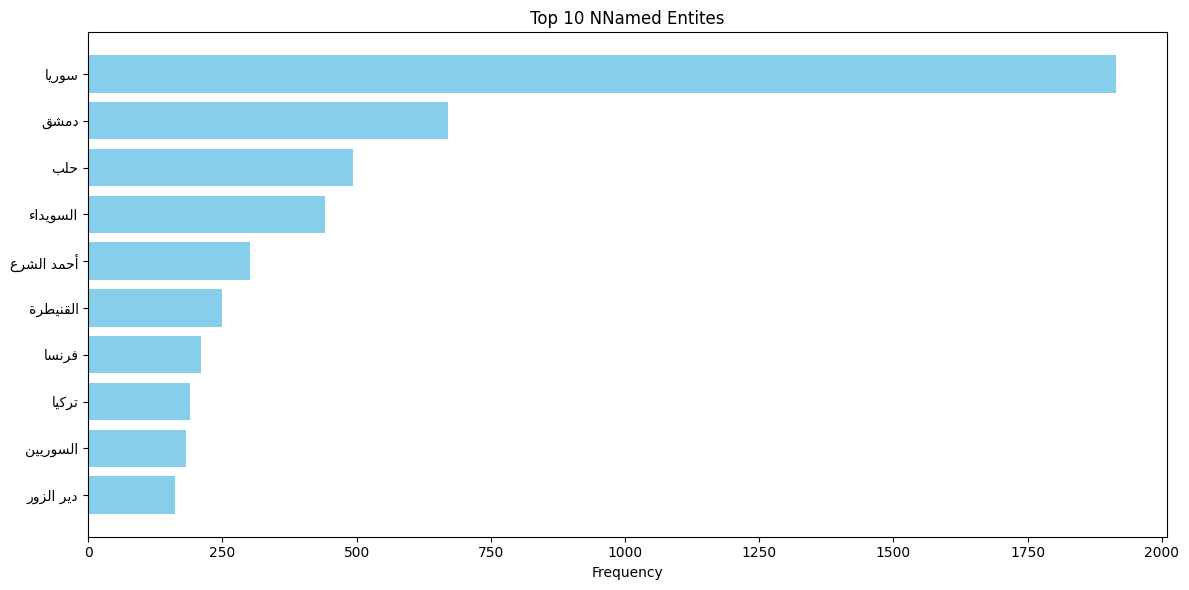

In [ ]:
#@title Top Named Entities
# Flatten all named entities from the dataframe column into a single list
all_entities = [ent for sublist in df['Named Entities'] for ent in sublist]

# Count frequency of each entity
entity_counts = Counter(all_entities)

# Get top 10 entities and their counts
top_entities = entity_counts.most_common(10)
entities, counts = zip(*top_entities)

# Reshape and reorder Arabic entity labels for correct display
reshaped_entities = [get_display(arabic_reshaper.reshape(ent)) for ent in entities]

# Plot bar chart
plt.figure(figsize=(12, 6))
plt.barh(reshaped_entities[::-1], counts[::-1], color='skyblue')  # reversed for descending order
plt.xlabel('Frequency')
plt.title("Top 10 NNamed Entites")
plt.tight_layout()
plt.show()


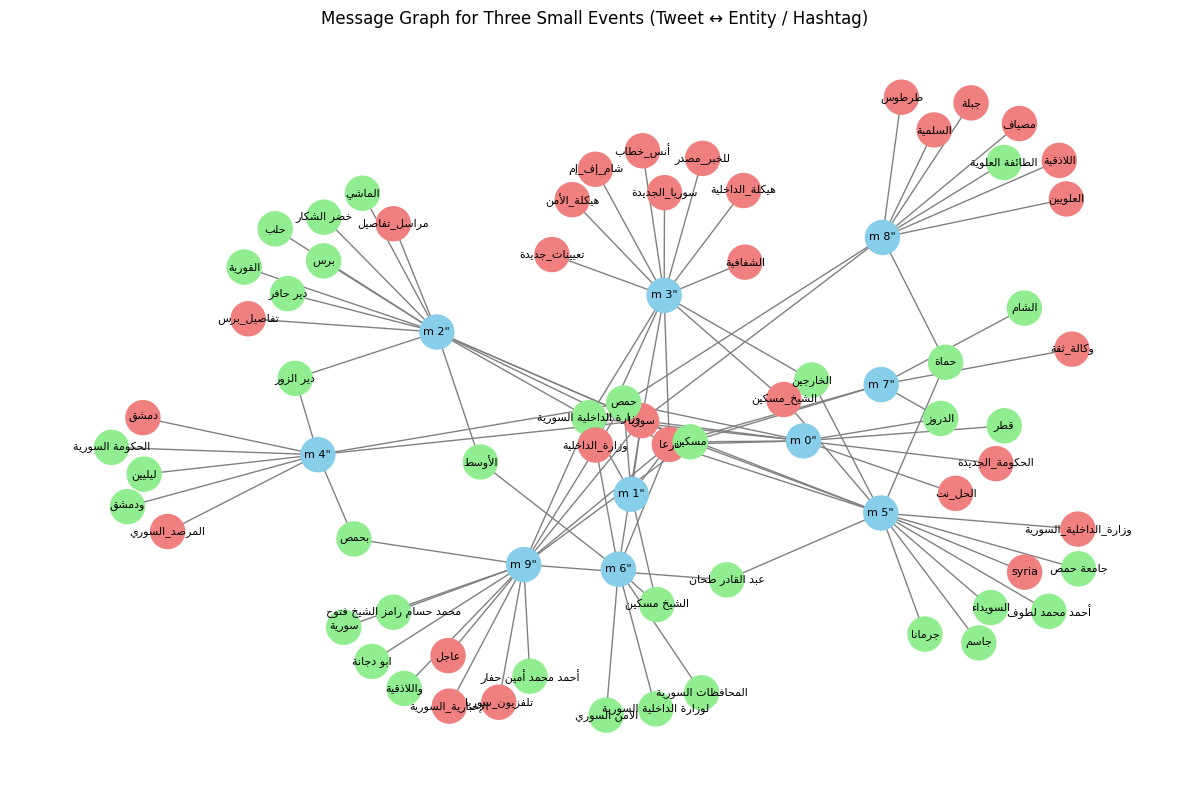

In [ ]:
#@title Heterogeneous Information Graph

# Pick three small events with tweet counts between 6 and 19
small_events = tweet_counts[(tweet_counts < 15) & (tweet_counts > 10)].index.tolist()
selected_events = random.sample(small_events, 3)

# Filter tweets for those events
df_subset = df[df['event_label'].isin(selected_events)]

# Initialize the graph
G = nx.Graph()

# Add tweet nodes and connect to entities and hashtags
for idx, row in df_subset.iterrows():
    tweet_node = f"m {str(row['Tweet ID'])[-2:]}"
    G.add_node(tweet_node, label='tweet', color='skyblue')

    # Connect entities (reshape and bidi for Arabic display)
    for entity in row['Named Entities']:
        entity_text_raw = entity
        reshaped_entity = arabic_reshaper.reshape(entity_text_raw)
        entity_text = get_display(reshaped_entity)
        G.add_node(entity_text, label='entity', color='lightgreen')
        G.add_edge(tweet_node, entity_text)

    # Connect hashtags (if column exists)
    for hashtag in row['Hashtags']:
        hashtag_text_raw = f"{hashtag.lower()}"
        reshaped = arabic_reshaper.reshape(hashtag_text_raw)
        hashtag_text = get_display(reshaped)
        G.add_node(hashtag_text, label='hashtag', color='lightcoral')
        G.add_edge(tweet_node, hashtag_text)
# Draw the graph
pos = nx.spring_layout(G, seed=42)
node_colors = [data['color'] for _, data in G.nodes(data=True)]

plt.figure(figsize=(12, 8))
nx.draw_networkx(
    G, pos,
    with_labels=True,
    node_color=node_colors,
    font_size=8,
    node_size=600,
    edge_color='gray'
)
plt.title("Message Graph for Three Small Events (Tweet ↔ Entity / Hashtag)")
plt.axis('off')
plt.tight_layout()
plt.show()

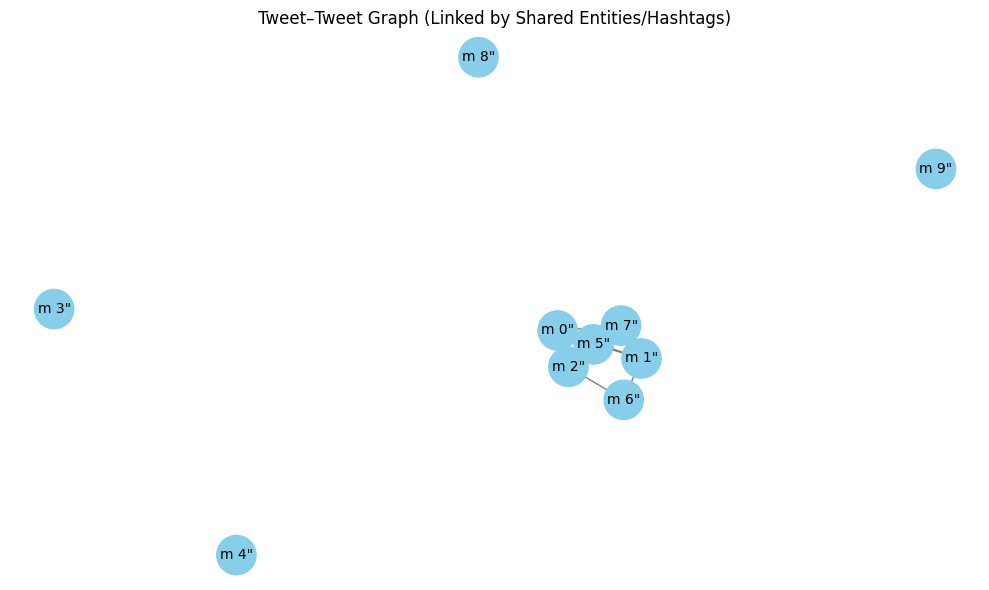

In [ ]:
#@title Messages Relation Graph
# Initialize the graph
G = nx.Graph()

# Mapping from tweet node to its set of entities
tweet_entities = {}

# Build tweet nodes and store their entities
for _, row in df_subset.iterrows():
    tweet_node = f"m {str(row['Tweet ID'])[-2:]}"  # Shortened ID
    G.add_node(tweet_node, label='tweet', color='skyblue')

    # Collect text of entities (and hashtags if needed)
    entities = {e.lower() for e in row['Named Entities']}
    tweet_entities[tweet_node] = entities

# Add edges only between tweets sharing entities
tweet_nodes = list(tweet_entities.keys())
for i in range(len(tweet_nodes)):
    for j in range(i + 1, len(tweet_nodes)):
        t1, t2 = tweet_nodes[i], tweet_nodes[j]
        shared = tweet_entities[t1].intersection(tweet_entities[t2])
        if shared:
            G.add_edge(t1, t2, shared_entities=', '.join(shared))

# Draw the simplified tweet-only graph
pos = nx.spring_layout(G, seed=42)
node_colors = [data['color'] for _, data in G.nodes(data=True)]

plt.figure(figsize=(10, 6))
nx.draw_networkx(
    G, pos,
    with_labels=True,
    node_color=node_colors,
    font_size=10,
    node_size=800,
    edge_color='gray'
)
plt.title("Tweet–Tweet Graph (Linked by Shared Entities/Hashtags)")
plt.axis('off')
plt.tight_layout()
plt.show()


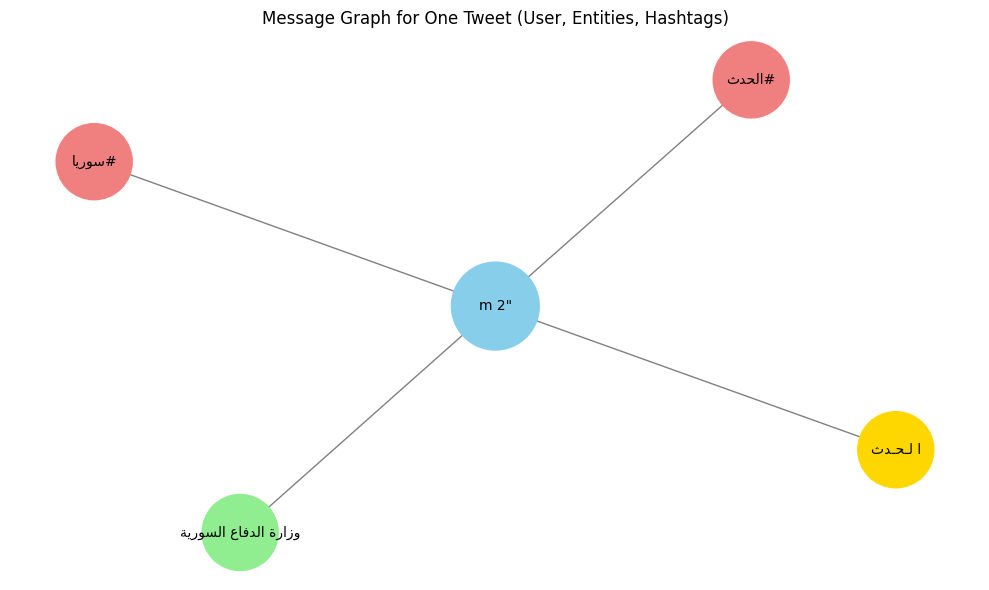

In [ ]:
#@title Message Graph for One Tweet (Arabic reshaped)

import arabic_reshaper
from bidi.algorithm import get_display

# Filter small events and pick one tweet
df_small = df[df['event_label'].isin(small_events)]

# Choose one tweet from this subset
one_tweet = df.sample(1).iloc[0]

# Initialize the graph
G = nx.Graph()
tweet_node = f"m {str(one_tweet['Tweet ID'])[-2:]}"  # Short ID

# Reshape and display author name in Arabic
user_raw = one_tweet['Author Name']
reshaped_user = arabic_reshaper.reshape(str(user_raw))
user_node = get_display(reshaped_user)

# Add tweet node
G.add_node(tweet_node, label='tweet', color='skyblue', size=4000)

# Add user node and connect
G.add_node(user_node, label='user', color='gold', size=3000)
G.add_edge(user_node, tweet_node)

# Add entity nodes and edges
for entity in one_tweet['Named Entities']:
    raw_entity = entity.strip().lower()
    reshaped_entity = arabic_reshaper.reshape(raw_entity)
    entity_text = get_display(reshaped_entity)
    G.add_node(entity_text, label='entity', color='lightgreen', size=3000)
    G.add_edge(tweet_node, entity_text)

# Add hashtag nodes and edges
for hashtag in one_tweet.get('Hashtags', []):
    raw_hashtag = f"#{hashtag.lower()}"
    reshaped_hashtag = arabic_reshaper.reshape(raw_hashtag)
    hashtag_text = get_display(reshaped_hashtag)
    G.add_node(hashtag_text, label='hashtag', color='lightcoral', size=3000)
    G.add_edge(tweet_node, hashtag_text)

# Draw the graph
pos = nx.spring_layout(G, seed=42)
node_colors = [data['color'] for _, data in G.nodes(data=True)]
node_sizes = [data['size'] for _, data in G.nodes(data=True)]

plt.figure(figsize=(10, 6))
nx.draw_networkx(
    G, pos,
    with_labels=True,
    node_color=node_colors,
    node_size=node_sizes,
    font_size=10,
    edge_color='gray'
)
plt.title("Message Graph for One Tweet (User, Entities, Hashtags)")
plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
#@title Save the dataset
df.to_csv('/content/drive/MyDrive/cleaned_merged_labeled_events.csv', index=False)
df.to_csv('/content/drive/MyDrive/merged_labeled_events.csv', index=False)


## Conclusion

## Refrences
